In [1]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from dsa_analysis import load_config, visualize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
import main
from main import RNNLayer
import ast

%load_ext autoreload
%autoreload 2

/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


### Load config

In [2]:
config = load_config("../config.yaml")

In [3]:
def parse_model_info(model_name):
    model_name = model_name.replace('.pth', '')
    model_name = model_name.split('_')
    model_type = model_name[0] + '_' + model_name[1]
    if len(model_name) == 8:    
        activation = model_name[2] + '_' + model_name[3]
        hidden_size = int(model_name[4])
        learning_rate = float(model_name[5])
        batch_size = int(model_name[6])
    else:
        activation = model_name[2]
        hidden_size = int(model_name[3])
        learning_rate = float(model_name[4])
        batch_size = int(model_name[5])
    return model_type, activation, hidden_size, learning_rate, batch_size

parse_model_info('leaky_gru_leaky_relu_128_0.001_128_train.pth')



('leaky_gru', 'leaky_relu', 128, 0.001, 128)

In [4]:
def get_dynamics_model(rnn_type, activation, hidden_size, lr, model, group,device, n_components=3):
    # Load configuration and set hyperparameters
    config = load_config("../config.yaml")
    ruleset = config["rules_analysis"][-1]
    all_rules = config["rules_analysis"]

    hp = {
        "rnn_type": rnn_type,
        "activation": activation,
        "n_rnn": hidden_size,
        "learning_rate": lr,
        "l2_h": 0.00001,
        "l2_weight": 0.00001,
        "mode": "test",
    }
    hp, _, _ = main.set_hyperparameters(
        model_dir="debug", hp=hp, ruleset=all_rules, rule_trains=ruleset
    )
    run_model = main.load_model(
        f"../models/{group}/{model}",
        hp,
        RNNLayer,
        device=device,
    )
    h = main.representation(run_model, all_rules)
    h_trans, explained_variance = main.compute_pca(h, n_components=n_components)
    tensor_on_cpu = h_trans[("AntiPerceptualDecisionMakingDelayResponseT", "stimulus")].cpu()
    return tensor_on_cpu.detach().numpy(), explained_variance

### Get dynamics to plot

In [5]:
model = "leaky_rnn_softplus_256_0.001_128_train.pth"

#### Pretrain unfrozen

In [6]:
group = "pretrain_unfrozen"
model_type, activation, hidden_size, lr, batch_size = parse_model_info(model)
curve, explained_variance = get_dynamics_model(
    model_type, activation, hidden_size, lr, model, group, "cpu", n_components=3 
)

/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: Th

#### Visualize the curves

/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


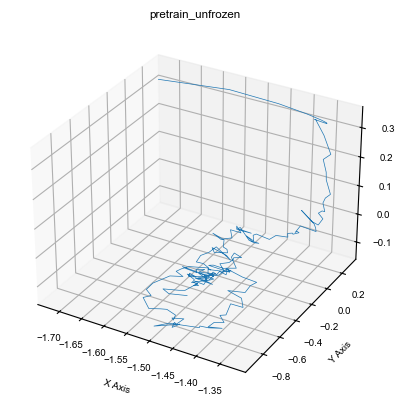

In [7]:
visualize([curve[:,100,:]],title=group)

#### Pretrain frozen

In [8]:
group = "pretrain_frozen"
model_type, activation, hidden_size, lr, batch_size = parse_model_info(model)
curve, explained_variance = get_dynamics_model(
    model_type, activation, hidden_size, lr, model, group, "cpu", n_components=3 
)

/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.

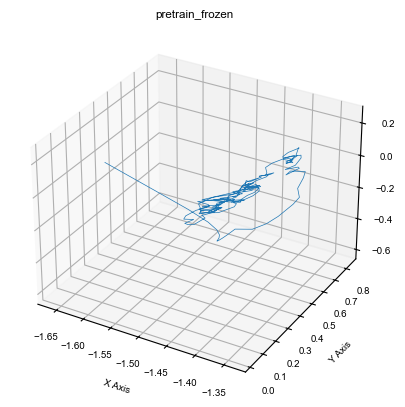

In [9]:
visualize([curve[:,100,:]],title=group)

#### master

In [10]:
group = "master"
model_type, activation, hidden_size, lr, batch_size = parse_model_info(model)
curve, explained_variance = get_dynamics_model(
    model_type, activation, hidden_size, lr, model, group, "cpu", n_components=3 
)

/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.

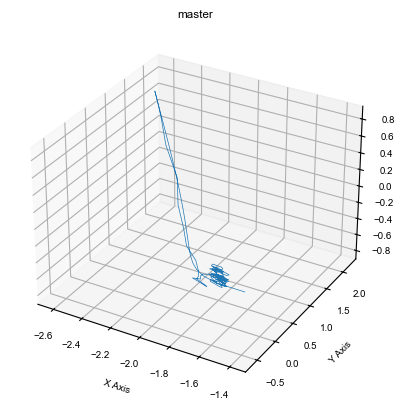

In [11]:
visualize([curve[:,100,:]],title=group)

### Get dissimilarities

#### Computation dynamics

In [12]:
# load data
path = "../data/dissimilarities"
files = os.listdir(path)
data = []
for file in files:
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(path, file))
        data.append(df)
data = pd.concat(data)

# Create a new DataFrame with swapped values
df_swapped = data.rename(columns={"model1": "model2", "model2": "model1", "group1": "group2", "group2": "group1"})

# Concatenate the original DataFrame with the swapped DataFrame
data = pd.concat([data, df_swapped], ignore_index=True)

data_groupes_mean_dissimilarity = data.groupby(['group1', 'group2'])[["cka","procrustes","dsa"]].median().reset_index()
data_models = data[data['model1'] == data['model2']].groupby(['group1', 'group2','model1','model2'])[["cka","procrustes","dsa"]].median().reset_index()
data_models_averaged = data_models.groupby(['group1', 'group2'])[["cka","procrustes","dsa"]].median().reset_index()

##### Dissimilarities Many to Many models

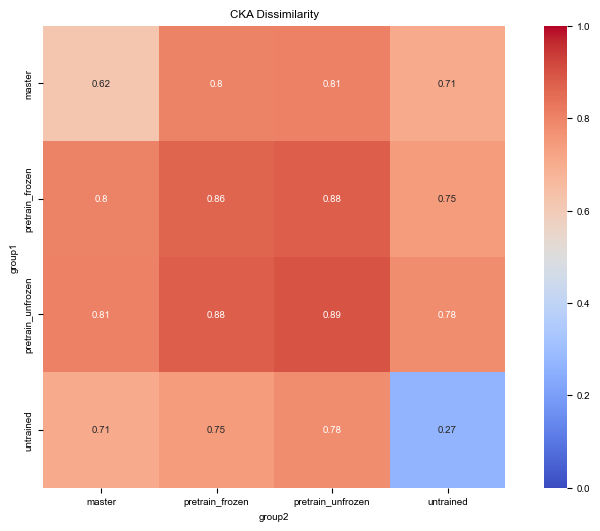

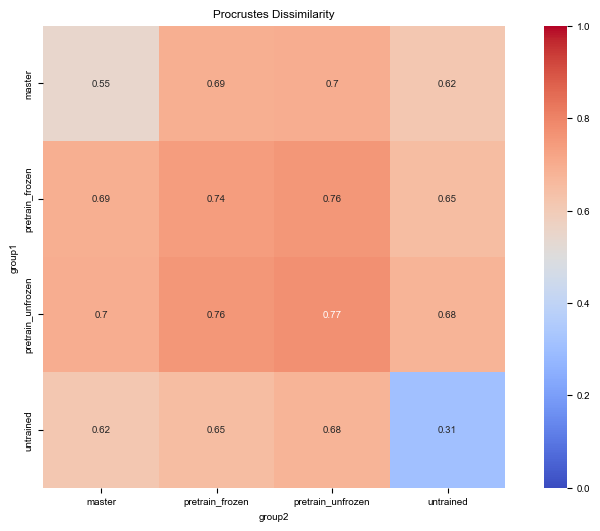

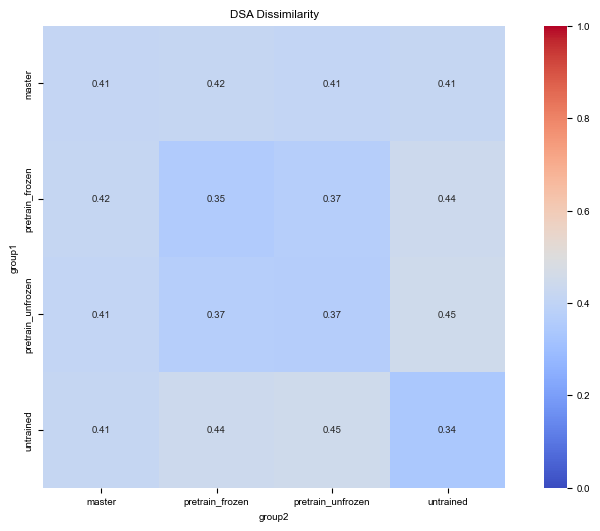

In [13]:
# plot heatmap of the dissimilarity between the groups
df = pd.DataFrame(data_groupes_mean_dissimilarity)

# Pivot the dataframe to prepare for heatmap
pivot_df = df.pivot(index='group1', columns='group2', values=['cka', 'procrustes', 'dsa'])

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df['cka'], annot=True, cmap='coolwarm', cbar=True, vmin=0, vmax=1, square=True)
plt.title('CKA Dissimilarity')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df['procrustes'], annot=True, cmap='coolwarm', cbar=True, vmin=0, vmax=1, square=True)
plt.title('Procrustes Dissimilarity')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df['dsa'], annot=True, cmap='coolwarm', cbar=True, vmin=0, vmax=1, square=True)
plt.title('DSA Dissimilarity')
plt.show()

##### Dissimilarities One to One models

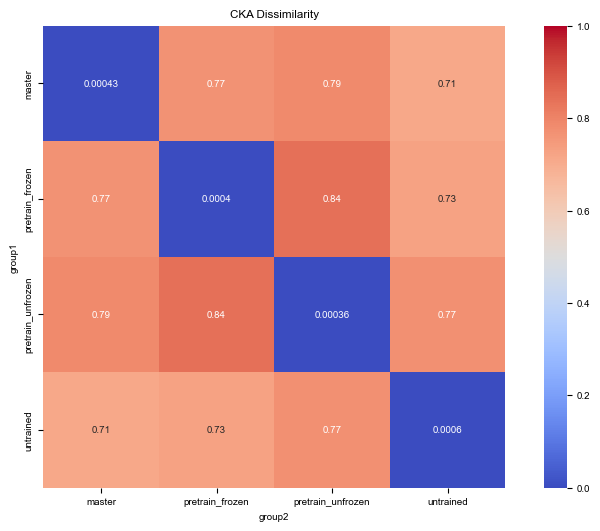

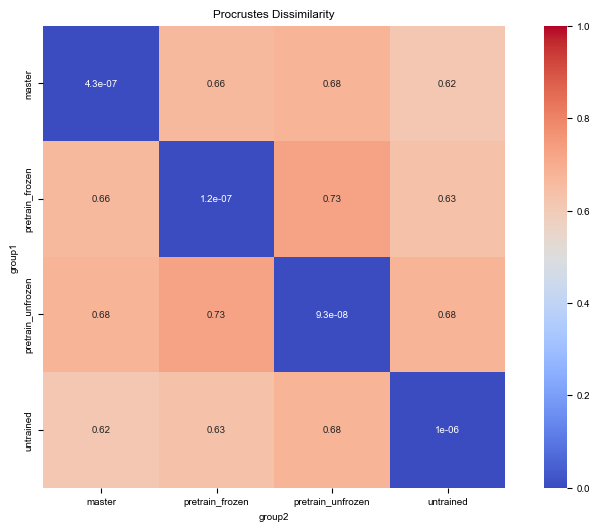

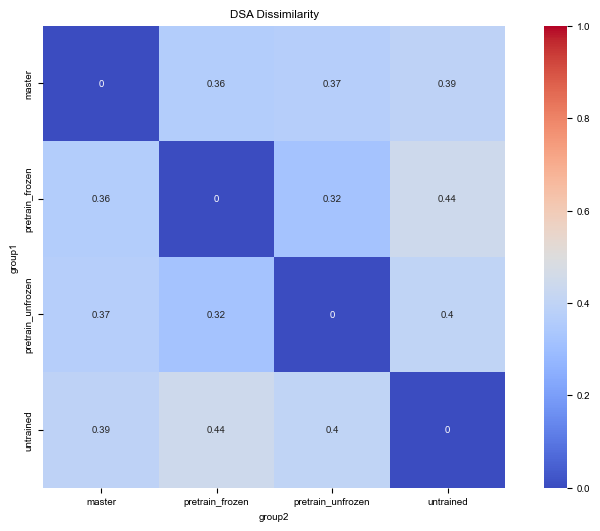

In [14]:
# plot heatmap of the dissimilarity between the groups
df = pd.DataFrame(data_models_averaged)

# Pivot the dataframe to prepare for heatmap
pivot_df = df.pivot(index='group1', columns='group2', values=['cka', 'procrustes', 'dsa'])

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df['cka'], annot=True, cmap='coolwarm', cbar=True, vmin=0, vmax=1, square=True)
plt.title('CKA Dissimilarity')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df['procrustes'], annot=True, cmap='coolwarm', cbar=True, vmin=0, vmax=1, square=True)
plt.title('Procrustes Dissimilarity')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df['dsa'], annot=True, cmap='coolwarm', cbar=True, vmin=0, vmax=1, square=True)
plt.title('DSA Dissimilarity')
plt.show()

#### Learning dynamics

For now, only analysis for pretrain_frozen against pretrain_unfrozen

In [15]:
path = "../data/dissimilarities_over_learning"
files = os.listdir(path)
data = []
for file in files:
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(path, file))
        data.append(df)
df = pd.concat(data)
df['cka'] = df['cka'].apply(ast.literal_eval)
df['procrustes'] = df['procrustes'].apply(ast.literal_eval)
df['dsa'] = df['dsa'].apply(ast.literal_eval)
df['accuracy_1'] = df['accuracy_1'].apply(ast.literal_eval)
df["accuracy_2"] = df["accuracy_2"].apply(ast.literal_eval)
# Create a new DataFrame with swapped values
df_swapped = df.rename(columns={"group1": "group2", "group2": "group1"})

# Concatenate the original DataFrame with the swapped DataFrame
df = pd.concat([df, df_swapped], ignore_index=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.946494070180032, 0.8220580861866806, 0.8332659244928287, 0.8107872246972067, 0.8042126790315655, 0.8047559754505227, 0.8041896699469765, 0.8026420695461256, 0.8022968619219818, 0.8112863517825474, 0.787999184926058, 0.7862458545403036, 0.8100157029093307, 0.8085301307646409, 0.821430845934175, 0.8061465702071479, 0.8202135775010005]
[0.0, 5.88235294117647, 11.76470588235294, 17.647058823529413, 23.52941176470588, 29.411764705882355, 35.294117647058826, 41.17647058823529, 47.05882352941176, 52.94117647058824, 58.82352941176471, 64.70588235294117, 70.58823529411765, 76.47058823529412, 82.35294117647058, 88.23529411764706, 94.11764705882352]


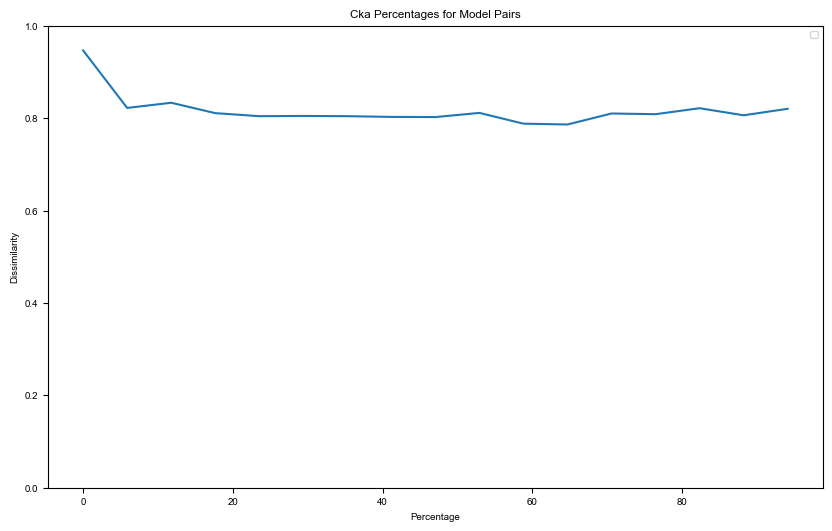

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.8285261920212937, 0.7130339010194836, 0.7146597787690129, 0.7006491706492031, 0.6975872942964042, 0.7033091683632615, 0.6981120208111897, 0.6940318135932529, 0.7012042890896694, 0.6990838834824489, 0.6942704405194187, 0.6902596191711877, 0.7014583261426262, 0.7040052887226017, 0.7102625413257041, 0.7015763239838294, 0.7115474745238957]
[0.0, 5.88235294117647, 11.76470588235294, 17.647058823529413, 23.52941176470588, 29.411764705882355, 35.294117647058826, 41.17647058823529, 47.05882352941176, 52.94117647058824, 58.82352941176471, 64.70588235294117, 70.58823529411765, 76.47058823529412, 82.35294117647058, 88.23529411764706, 94.11764705882352]


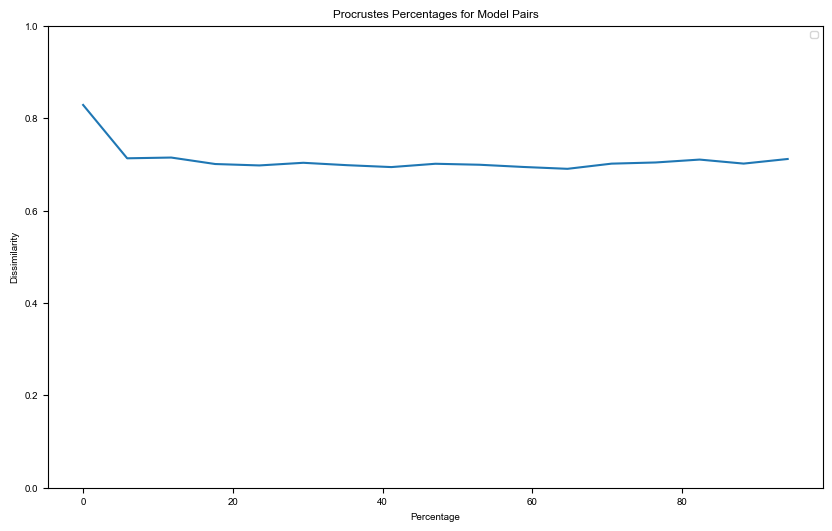

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.3235202133655548, 0.36308643221855164, 0.3598328232765198, 0.3881540596485138, 0.35779789090156555, 0.3689291775226593, 0.3544415235519409, 0.3461395502090454, 0.37496912479400635, 0.3545224070549011, 0.3620009124279022, 0.37475720047950745, 0.36083632707595825, 0.36298421025276184, 0.351144939661026, 0.3821162283420563, 0.360543429851532]
[0.0, 5.88235294117647, 11.76470588235294, 17.647058823529413, 23.52941176470588, 29.411764705882355, 35.294117647058826, 41.17647058823529, 47.05882352941176, 52.94117647058824, 58.82352941176471, 64.70588235294117, 70.58823529411765, 76.47058823529412, 82.35294117647058, 88.23529411764706, 94.11764705882352]


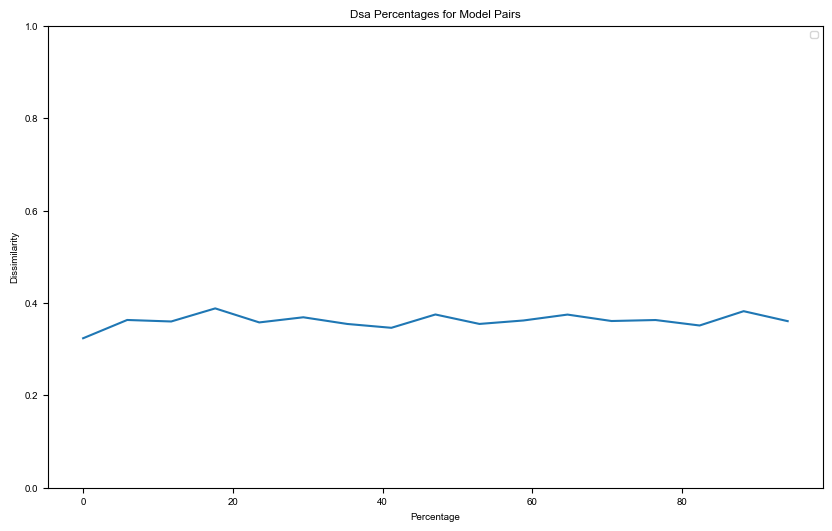

KeyError: 'accurary_1'

<Figure size 1000x600 with 0 Axes>

In [16]:
# Fix group1 and group2
group1_fixed = "pretrain_frozen"
group2_fixed = "pretrain_unfrozen"
rnn_type = "leaky_rnn"
activation = "leaky_relu"
hidden_size = 128
learning_rate = 0.001
batch_size = 256

df_filtered = df[(df['group1'] == group1_fixed) & (df['group2'] == group2_fixed) & (df['rnn_type'] == rnn_type) & (df['activation'] == activation) & (df['hidden_size'] == hidden_size) & (df['lr'] == learning_rate) & (df['batch_size'] == batch_size)]

# Plotting
def plot_measure(measure):
    plt.figure(figsize=(10, 6))
    
    for index, row in df_filtered.iterrows():
        values = row[measure]
        print(values)
        percentages = [(index / len(values)) * 100 for index in range(len(values))]
        print(percentages)
        plt.plot(percentages, values)
    
    plt.title(f'{measure.capitalize()} Percentages for Model Pairs')
    plt.xlabel('Percentage')
    plt.ylabel('Dissimilarity')
    plt.ylim(0, 1) 
    plt.legend()
    plt.show()

# Plotting for cka, procrustes, and dsa
plot_measure('cka')
plot_measure('procrustes')
plot_measure('dsa')
plot_measure('accurary_1')

In [ ]:
# Fix group1 and group2
group1_fixed = "pretrain_unfrozen"
group2_fixed = "master"
# Define the percentages
percentages = [i for i in range(0, 101, 20)]

df_group1_group2 = df[(df['group1'] == group1_fixed) & (df['group2'] == group2_fixed)]

NameError: name 'df' is not defined

In [ ]:
df_group1_group2 = df_group1_group2[df_group1_group2['dsa'].apply(len).between(1, 49)]

In [ ]:
df_group1_group2

,group1,group2,rnn_type,activation,hidden_size,lr,batch_size,cka,procrustes,dsa,accuracy_1,accuracy_2
131,pretrain_unfrozen,master,leaky_rnn,leaky_relu,128,0.0010,256,"[0.8155807388239941, 0.8102785308484898, 0.802...","[0.7016976058890333, 0.6959778052215819, 0.694...","[0.3729535937309265, 0.3735423684120178, 0.366...","[[0.8739607334136963], [0.8739607334136963, 0....","[[0.0], [0.0, 0.024392222985625267, 0.27828273..."
134,pretrain_unfrozen,master,leaky_rnn,leaky_relu,256,0.0010,128,[0.8084970672686903],[0.66988934332414],[0.3789033889770508],[[0.984887957572937]],[[0.3334285318851471]]
135,pretrain_unfrozen,master,leaky_rnn,leaky_relu,256,0.0010,256,"[0.8111286135745224, 0.8286449627672038, 0.823...","[0.7408447581750642, 0.7385751688959911, 0.741...","[0.30853691697120667, 0.3484005928039551, 0.31...","[[0.9308921098709106], [0.9308921098709106, 0....","[[0.16686369478702545], [0.16686369478702545, ..."
138,pretrain_unfrozen,master,leaky_rnn,relu,128,0.0010,128,[0.799747453142346],[0.6924409363972054],[0.3936108648777008],[[0.9819048047065735]],[[0.05446009337902069]]
139,pretrain_unfrozen,master,leaky_rnn,relu,128,0.0010,256,[0.8035523338557551],[0.6910572249878596],[0.38096991181373596],[[0.9806957840919495]],[[0.0]]
140,pretrain_unfrozen,master,leaky_rnn,relu,256,0.0001,128,"[0.6273957387406379, 0.626247445505039, 0.6351...","[0.620598809412857, 0.6127935356425929, 0.6220...","[0.34764590859413147, 0.3483607769012451, 0.34...","[[0.841422438621521], [0.841422438621521, 0.87...","[[0.0], [0.0, 0.0], [0.0, 0.0, 0.0942293703556..."
142,pretrain_unfrozen,master,leaky_rnn,relu,256,0.0010,128,"[0.7240231138012644, 0.7406491923867233, 0.751...","[0.6647103739455916, 0.6745154132354219, 0.674...","[0.36927133798599243, 0.3520331382751465, 0.36...","[[0.8723527193069458], [0.8723527193069458, 0....","[[0.3281744122505188], [0.3281744122505188, 0...."
143,pretrain_unfrozen,master,leaky_rnn,relu,256,0.0010,256,[0.8058199628108358],[0.6978291564314661],[0.369178831577301],[[0.9587904214859009]],[[0.0]]
154,pretrain_unfrozen,master,leaky_rnn,tanh,128,0.0010,128,"[0.9907703534076774, 0.9891925792451047, 0.990...","[0.9047288073419978, 0.8943341425457656, 0.910...","[0.4204660952091217, 0.4069622755050659, 0.392...","[[0.9433701038360596], [0.9433701038360596, 0....","[[0.2517646253108978], [0.2517646253108978, 0...."
158,pretrain_unfrozen,master,leaky_rnn,tanh,256,0.0010,128,"[0.9965666083649155, 0.9973339974392214, 0.997...","[0.9489508416599923, 0.9552264639979609, 0.954...","[0.4402960538864136, 0.44304943084716797, 0.42...","[[0.5665537118911743], [0.5665537118911743, 0....","[[0.32842305302619934], [0.32842305302619934, ..."


In [ ]:
# Filter out empty lists in 'dsa'
filtered_dsa = df_group1_group2['dsa'].apply(lambda x: len(x) if x else None).dropna()

# Calculate statistics
filtered_dsa.describe()

count    28.000000
mean     16.178571
std      15.487279
min       1.000000
25%       3.750000
50%       9.500000
75%      24.750000
max      45.000000
Name: dsa, dtype: float64

/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


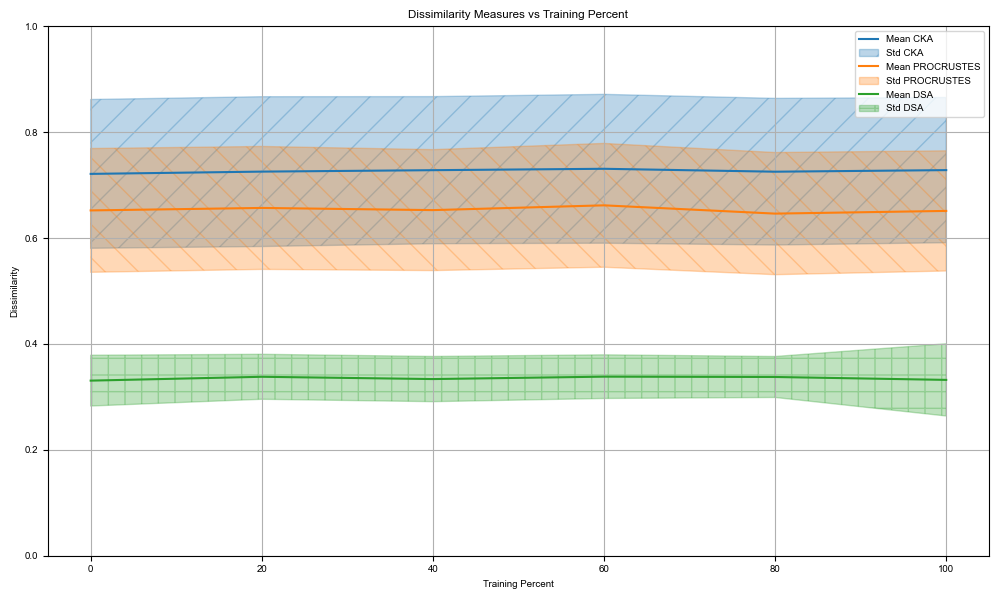

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Function to interpolate and sample at fixed percentages
def interpolate_and_sample(measures_list, percentages):
    if not measures_list:
        return [np.nan] * len(percentages)
    
    original_percentages = np.linspace(0, 100, len(measures_list))
    interpolation_function = interp1d(original_percentages, measures_list, kind='linear', fill_value="extrapolate")
    return interpolation_function(percentages)

# Apply interpolation and sampling to each row
for measure in ['cka', 'procrustes', 'dsa']:
    df_group1_group2[measure + '_interpolated'] = df_group1_group2[measure].apply(lambda x: interpolate_and_sample(x, percentages))

# Calculate the mean and standard deviation for each measure
summary_stats = {}
for measure in ['cka', 'procrustes', 'dsa']:
    interpolated_values = np.array(df_group1_group2[measure + '_interpolated'].tolist())
    summary_stats[measure] = {
        'median': np.nanmedian(interpolated_values, axis=0),
        'std': np.nanstd(interpolated_values, axis=0)
    }

# Plotting
plt.figure(figsize=(10, 6))

# Plot each measure with different colors and hatching patterns for uncertainty
for i, measure in enumerate(['cka', 'procrustes', 'dsa']):
    median = summary_stats[measure]['median']
    std = summary_stats[measure]['std']
    color = f"C{i}"  # Cycle through different colors
    hatch = "/" if i == 0 else "\\" if i == 1 else "+"  # Different hatching patterns
    
    plt.plot(percentages, median, color=color, label=f"Mean {measure.upper()}")
    plt.fill_between(percentages, median - std, median + std, color=color, alpha=0.3, hatch=hatch, label=f"Std {measure.upper()}")

plt.title('Dissimilarity Measures vs Training Percent')
plt.xlabel('Training Percent')
plt.ylabel('Dissimilarity')
plt.ylim(0, 1)  # Set y-axis range between 0 and 1
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
